# GSA Project - Charting the Storm: Using GeoSpatial Insights for Evacuation Planning

<b>Submitted by:</b> Pati, Anish; Saringan, Alyannah Bianca

<b>Output:</b> Assess risk per baranggay level and recommend evacuation centers

<b>Methodology:</b> \
Calculate percentage of population affected by flood:
1. Locate most urbanized areas in a baranggay: Locate amenities
2. Distribute majority of population in urbanized areas: Assign a population per amenity point based on total population per baranggay and distribute evenly
3. Get number of population affected by flood: Get overlap between flood area versus amenity points (with corresponding population number)
4. Rank most affected based on number of population affected per baranggay level
5. Assign centroid for top baranggays based on amenties impacted
- Notes: Amenity vs Equal vs Centroid comparison for pop impact

Identify appropriate evacuation zones for populations that are most at risk:
1. Create list of amenities with potential evacuation points (ex. school, church) and assign capacity based on research
2. Check evacuation point closest to affected baranggay assigned centroid
3. Check if population impacted will fit inside evacuation point. If there are still impacted population left, minus the evacuated population from the total impacted and repeat process
4. Stop checking for evacuation points once population from affected baranggay has been assigned to evacuation points fully.

<b>References:</b>
- https://www.philstar.com/headlines/climate-and-environment/2023/01/30/2241342/why-philippines-needs-stop-using-schools-evacuation-centers
- https://ojs.wpro.who.int/ojs/index.php/wpsar/article/download/338/566?inline=1

## Import libraries and connect to SQL

In [1]:
# Import libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import psycopg2
import numpy as np
import pandas as pd
from shapely.geometry import Point, LineString, Polygon, MultiPoint
from matplotlib.colors import ListedColormap

# Connect to SQL
conn = psycopg2.connect(dbname="postgis",
                        user="gsa2022",
                        password="g5!V%T1Vmd",
                        host="192.168.212.99",
                        port=32771)

# Display max columns
pd.set_option('display.max_columns', 200)

## Load datasets

### Load barangay population dataset

In [2]:
df_pop = pd.read_excel('2020-census-total-popn-brgy_adm4_new-pcode.xlsx')

### Load Metro Manila amenity points shapefile

In [3]:
pts_mm_amenity = gpd.read_postgis(
    """
    SELECT
        p.*
    FROM
        ph_point as p
    JOIN
        gadm.ph as g
    ON
        st_within(p.way, g.geom)
    WHERE
        p.amenity != 'None'
    AND
        g.name_1 = 'Metropolitan Manila'
    """,
    conn,
    geom_col='way'
)

/opt/conda/lib/python3.10/site-packages/geopandas/io/sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


### Load Philippine barangay-level shapefile

In [4]:
shp_ph = gpd.read_postgis(
    """
    SELECT
        *
    FROM
        gadm.ph_brgy
    """,
    conn,
    geom_col='geom')

/opt/conda/lib/python3.10/site-packages/geopandas/io/sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


### Load Metro Manila barangay-level shapefile

In [5]:
shp_mm = gpd.read_postgis(
    """
    SELECT
        *
    FROM
        gadm.ph_brgy
    WHERE
        name_1 = 'Metropolitan Manila'
    """,
    conn,
    geom_col='geom')

/opt/conda/lib/python3.10/site-packages/geopandas/io/sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


### Load Metro Manila 5-year flood shapefile

In [6]:
shp_mm_flood = gpd.read_file('MetroManila_Flood_5year.shp')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Data preprocessing

### Limit population dataset to Metro Manila

In [7]:
df_pop.columns = df_pop.columns.str.lower()
df_mm_pop = df_pop[df_pop['region'] == 'National Capital Region (NCR)']

### Match population and Metro Manila shapefile city names

In [8]:
# Create new column for cleaned city names
df_mm_pop.loc[:, 'mun_city_new'] = df_mm_pop['mun_city']

# Match Metro Manila city names
mapping_mun_city = {
    'City of Manila': 'Manila',
    'City of Mandaluyong': 'Mandaluyong',
    'City of Marikina': 'Marikina',
    'City of Pasig': 'Pasig City',
    'Quezon City': 'Quezon City',
    'City of San Juan': 'San Juan',
    'City of Caloocan': 'Kalookan City',
    'City of Malabon': 'Malabon',
    'City of Navotas': 'Navotas',
    'City of Valenzuela': 'Valenzuela',
    'City of Las Piñas': 'Las Piñas',
    'City of Makati': 'Makati City',
    'City of Muntinlupa': 'Muntinlupa',
    'City of Parañaque': 'Parañaque',
    'Pasay City': 'Pasay City',
    'Pateros': 'Pateros',
    'City of Taguig': 'Taguig'
}
df_mm_pop.loc[:, 'mun_city_new'] = df_mm_pop['mun_city_new'].replace(mapping_mun_city)

/tmp/ipykernel_40691/3932677769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mm_pop.loc[:, 'mun_city_new'] = df_mm_pop['mun_city']
/tmp/ipykernel_40691/3932677769.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mm_pop.loc[:, 'mun_city_new'] = df_mm_pop['mun_city_new'].replace(mapping_mun_city)


### Match population and Metro Manila shapefile barangay names

In [9]:
# Manila and Las Piñas n.a. remain n.a. due to lack of information to impute

# Create new column for cleaned barangay names
df_mm_pop.loc[:, 'barangay_new'] = df_mm_pop['barangay']
shp_mm.loc[:, 'name_3_new'] = shp_mm['name_3']

# Match Makati barangays
mapping_brgy_makati_city = {
    'Rizal': 'Post Proper Southside'
}
df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Makati City', 'barangay_new'] = df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Makati City', 'barangay_new'].replace(mapping_brgy_makati_city)

# Match Malabon barangays
mapping_brgy_malabon = {
    'Bayan-bayanan': 'Bayan-Bayanan',
    'Santolan': 'Panghulo',
    'Tañong ': 'Tañong'
}
df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Malabon', 'barangay_new'] = df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Malabon', 'barangay_new'].replace(mapping_brgy_malabon)

# Match Mandaluyong barangays
mapping_brgy_mandaluyong = {
    'Pag-asa': 'Pag-Asa',
    'Wack-wack Greenhills': 'Wack-Wack Greenhills'
}
df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Mandaluyong', 'barangay_new'] = df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Mandaluyong', 'barangay_new'].replace(mapping_brgy_mandaluyong)

# Match Manila barangays
mapping_brgy_manila = {
    'Barangay 128': 'Barangay 129'
}
df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Manila', 'barangay_new'] = df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Manila', 'barangay_new'].replace(mapping_brgy_manila)

# Match Marikina barangays
mapping_brgy_marikina = {
    'Fortune': 'Parang',
    'Jesus De La Peña': 'Jesus de la Peña',
    'Santa Elena ': 'Santa Elena',
    'Tumana': 'Concepcion Uno'
}
df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Marikina', 'barangay_new'] = df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Marikina', 'barangay_new'].replace(mapping_brgy_marikina)

# Match Navotas barangays
mapping_name_3_navotas = {
    'n.a.': 'NBBS Dagat-dagatan'
}
mapping_brgy_navotas = {
    'NBBS Kaunlaran': 'North Bay Blvd., South',
    'NBBS Proper': 'North Bay Blvd., South',
    'Navotas West': 'Navotas East',
    'North Bay Boulevard North': 'North Bay Blvd., North',
    'San Jose ': 'San Jose',
    'Tangos North': 'Tangos',
    'Tangos South': 'Tangos',
    'Tanza 1': 'Tanza',
    'Tanza 2': 'Tanza'
}
shp_mm.loc[shp_mm['name_2'] == 'Navotas', 'name_3_new'] = shp_mm.loc[shp_mm['name_2'] == 'Navotas', 'name_3_new'].replace(mapping_name_3_navotas)
df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Navotas', 'barangay_new'] = df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Navotas', 'barangay_new'].replace(mapping_brgy_navotas)

# Match Paranaque barangays
mapping_brgy_paranaque = {
    'San Martin De Porres': 'San Martin de Porres'
}
df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Parañaque', 'barangay_new'] = df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Parañaque', 'barangay_new'].replace(mapping_brgy_paranaque)

# Match Pasay City barangays
mapping_name_3_pasay_city = {
    'n.a.': 'Barangay 76'
}
shp_mm.loc[shp_mm['name_2'] == 'Pasay City', 'name_3_new'] = shp_mm.loc[shp_mm['name_2'] == 'Pasay City', 'name_3_new'].replace(mapping_name_3_pasay_city)

# Match Pasig City barangays
mapping_brgy_pasig_city = {
    'San Nicolas ': 'San Nicolas'
}
df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Pasig City', 'barangay_new'] = df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Pasig City', 'barangay_new'].replace(mapping_brgy_pasig_city)

# Match Quezon City barangays
mapping_name_3_quezon_city = {
    'n.a.': 'Bagong Pag-Asa',
    'Constitution Hills': 'Commonwealth'
}
mapping_brgy_quezon_city = {
    'Bagong Pag-asa': 'Bagong Pag-Asa',
    'Duyan-duyan': 'Duyan-Duyan',
    'Greater Lagro': 'Pasong Putik Proper',
    'New Era': 'Bagong Pag-Asa',
    'North Fairview': 'Pasong Putik Proper',
    'Pag-ibig Sa Nayon': 'Pag-Ibig Sa Nayon',
    'San Martin De Porres': 'San Martin de Porres',
    'Santo Domingo': 'Matalahib'
}
shp_mm.loc[shp_mm['name_2'] == 'Quezon City', 'name_3_new'] = shp_mm.loc[shp_mm['name_2'] == 'Quezon City', 'name_3_new'].replace(mapping_name_3_quezon_city)
df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Quezon City', 'barangay_new'] = df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Quezon City', 'barangay_new'].replace(mapping_brgy_quezon_city)

# Match San Juan barangays
mapping_brgy_san_juan = {
    'Addition Hills': 'Greenhills',
    'Corazon De Jesus': 'Corazon de Jesus',
    'Halo-halo': 'Halo-Halo'
}
df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'San Juan', 'barangay_new'] = df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'San Juan', 'barangay_new'].replace(mapping_brgy_san_juan)

# Match Taguig barangays
mapping_brgy_taguig = {
    'Central Bicutan': 'Upper Bicutan',
    'Central Signal Village': 'Signal Village',
    'Fort Bonifacio': 'Post Proper Southside',
    'Katuparan': 'Hagonoy',
    'New Lower Bicutan': 'Lower Bicutan',
    'North Daang Hari': 'Bagong Tanyag',
    'North Signal Village': 'Signal Village',
    'Pinagsama': 'Post Proper Southside',
    'San Miguel': 'Bambang',
    'South Daang Hari': 'Bagong Tanyag',
    'South Signal Village': 'Signal Village',
    'Tanyag': 'Bagong Tanyag'
}
mapping_mun_city_taguig = {
    'Taguig': 'Makati City'
}
df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Taguig', 'barangay_new'] = df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Taguig', 'barangay_new'].replace(mapping_brgy_taguig)
df_mm_pop.loc[df_mm_pop['barangay_new'] == 'Post Proper Southside', 'mun_city_new'] = df_mm_pop.loc[df_mm_pop['barangay_new'] == 'Post Proper Southside', 'mun_city_new'].replace(mapping_mun_city_taguig)

# Match Valenzuela barangays
mapping_brgy_valenzuela = {
    'Canumay East': 'Canumay',
    'Canumay West': 'Canumay',
    'Gen. T. De Leon': 'Hen. T. de Leon',
    'Paso De Blas': 'Paso de Blas'
}
df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Valenzuela', 'barangay_new'] = df_mm_pop.loc[df_mm_pop['mun_city_new'] == 'Valenzuela', 'barangay_new'].replace(mapping_brgy_valenzuela)

/tmp/ipykernel_40691/1674428179.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mm_pop.loc[:, 'barangay_new'] = df_mm_pop['barangay']


### Prepare simplified Metro Manila population dataset

In [10]:
# DataFrame of Population per Baranggay
df_mm_pop_new = df_mm_pop.groupby(['mun_city_new', 'barangay_new'])['2020 census popn'].sum().reset_index()
df_mm_pop_new = df_mm_pop_new.rename(
    columns={
        'mun_city_new': 'mun_city',
        'barangay_new': 'barangay',
        '2020 census popn': 'population'
    }
)
df_mm_pop_new.head()

,mun_city,barangay,population
0,Kalookan City,Barangay 1,2319.0
1,Kalookan City,Barangay 10,1485.0
2,Kalookan City,Barangay 100,983.0
3,Kalookan City,Barangay 101,2517.0
4,Kalookan City,Barangay 102,1033.0


### Prepare simplified Metro Manila barangay-level shapefile

In [11]:
# DataFrame of Metro Manila Shapefile
shp_mm_clean = shp_mm.dissolve(by=['name_2', 'name_3_new']).reset_index()
shp_mm_clean = shp_mm_clean.rename(
    columns={
        'name_1': 'province',
        'name_2': 'mun_city',
        'name_3_new': 'barangay'
    }
)

# DataFrame of Barangay Shape File
shp_mm_new = shp_mm_clean[['gid', 'province', 'mun_city', 'barangay', 'geom']]
shp_mm_new.head()

,gid,province,mun_city,barangay,geom
0,24355,Metropolitan Manila,Kalookan City,Barangay 1,"POLYGON ((120.96928 14.66245, 120.96929 14.662..."
1,24356,Metropolitan Manila,Kalookan City,Barangay 10,"POLYGON ((120.96791 14.65518, 120.96799 14.654..."
2,24357,Metropolitan Manila,Kalookan City,Barangay 100,"POLYGON ((120.99181 14.65265, 120.99107 14.653..."
3,24358,Metropolitan Manila,Kalookan City,Barangay 101,"POLYGON ((120.99307 14.65218, 120.99255 14.650..."
4,24359,Metropolitan Manila,Kalookan City,Barangay 102,"POLYGON ((120.99228 14.64971, 120.99199 14.649..."


### Prepare simplified Metro Manila amenity points shapefile

In [12]:
# DataFrame of All Amenity Points in Metro Manila
pts_mm_amenity_new = pts_mm_amenity[['osm_id', 'amenity', 'way']]
pts_mm_amenity_new.head()

,osm_id,amenity,way
0,1323171902,place_of_worship,POINT (121.06504 14.53979)
1,5055079422,nightclub,POINT (121.06733 14.53969)
2,255058348,school,POINT (121.06861 14.53961)
3,1323171838,place_of_worship,POINT (121.06228 14.54403)
4,255071432,school,POINT (121.06374 14.54548)


### Prepare unionized Metro Manila 5-year flood shapefile

In [13]:
# DataFrame of Flood Shape File
shp_mm_flood_new = shp_mm_flood.copy()
shp_mm_flood_new['union_geom'] = shp_mm_flood_new['geometry'].unary_union
shp_mm_flood_new = shp_mm_flood_new.head(1)
shp_mm_flood_new = shp_mm_flood_new[['union_geom']]
shp_mm_flood_new.head()

,union_geom
0,MULTIPOLYGON (((120.93808067368434 14.66589009...


## Compute for population affected per criteria type (area, centroid, amenity)

### DataFrame for Amenities - Adding Barangay, Amenity Affected Status

In [14]:
shp_mm_flood_new = gpd.GeoDataFrame(shp_mm_flood_new, geometry='union_geom')
pts_mm_amenity_new = gpd.sjoin(pts_mm_amenity_new, shp_mm_new, how='inner', predicate='within').drop(columns=['index_right'])
df_amenity_affected = gpd.sjoin(pts_mm_amenity_new, shp_mm_flood_new, how='inner', predicate='within').reset_index(drop=True).drop(columns=['index_right'])

/tmp/ipykernel_40691/1503081734.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  df_amenity_affected = gpd.sjoin(pts_mm_amenity_new, shp_mm_flood_new, how='inner', predicate='within').reset_index(drop=True).drop(columns=['index_right'])


In [15]:
df_amenity_affected

,osm_id,amenity,way,gid,province,mun_city,barangay
0,255058348,school,POINT (121.06861 14.53961),25827,Metropolitan Manila,Pateros,Martires Del 96
1,255071432,school,POINT (121.06374 14.54548),25825,Metropolitan Manila,Pateros,Aguho
2,1323171874,fuel,POINT (121.06797 14.54168),25830,Metropolitan Manila,Pateros,San Roque
3,1323171772,school,POINT (121.06709 14.54335),25831,Metropolitan Manila,Pateros,Santa Ana
4,4927836924,restaurant,POINT (121.06811 14.54563),25831,Metropolitan Manila,Pateros,Santa Ana
...,...,...,...,...,...,...,...
4439,5076770321,bus_station,POINT (120.99284 14.71022),26019,Metropolitan Manila,Valenzuela,Canumay
4440,5259237322,fast_food,POINT (120.99391 14.70938),26019,Metropolitan Manila,Valenzuela,Canumay
4441,5448469021,bus_station,POINT (120.99305 14.71099),26019,Metropolitan Manila,Valenzuela,Canumay
4442,5243747021,bus_station,POINT (120.99324 14.71170),26019,Metropolitan Manila,Valenzuela,Canumay


In [16]:
pts_mm_amenity_new['affected_amenity'] = pts_mm_amenity_new['osm_id'].isin(df_amenity_affected['osm_id'])

In [17]:
pts_mm_amenity_new.head()

,osm_id,amenity,way,gid,province,mun_city,barangay,affected_amenity
0,1323171902,place_of_worship,POINT (121.06504 14.53979),25827,Metropolitan Manila,Pateros,Martires Del 96,False
1,5055079422,nightclub,POINT (121.06733 14.53969),25827,Metropolitan Manila,Pateros,Martires Del 96,False
2,255058348,school,POINT (121.06861 14.53961),25827,Metropolitan Manila,Pateros,Martires Del 96,True
5,1748072940,bank,POINT (121.06709 14.54080),25827,Metropolitan Manila,Pateros,Martires Del 96,False
6,1993739420,school,POINT (121.06692 14.54115),25827,Metropolitan Manila,Pateros,Martires Del 96,False


### Dataframe for Barangay Shape File - Adding Flood Area Distribution

In [18]:
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='geom')
shp_mm_flood_new = gpd.GeoDataFrame(shp_mm_flood_new, geometry='union_geom')
df_intersection = shp_mm_new.overlay(shp_mm_flood_new, how='intersection')

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:2469: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.overlay(


In [19]:
df_intersection

,gid,province,mun_city,barangay,geometry
0,24355,Metropolitan Manila,Kalookan City,Barangay 1,"MULTIPOLYGON (((120.96984 14.65772, 120.96962 ..."
1,24356,Metropolitan Manila,Kalookan City,Barangay 10,"MULTIPOLYGON (((120.96798 14.65423, 120.96805 ..."
2,24357,Metropolitan Manila,Kalookan City,Barangay 100,"MULTIPOLYGON (((120.99166 14.65290, 120.99166 ..."
3,24358,Metropolitan Manila,Kalookan City,Barangay 101,"MULTIPOLYGON (((120.99272 14.65128, 120.99269 ..."
4,24359,Metropolitan Manila,Kalookan City,Barangay 102,"MULTIPOLYGON (((120.99243 14.65051, 120.99242 ..."
...,...,...,...,...,...
1660,26041,Metropolitan Manila,Valenzuela,Rincon,"MULTIPOLYGON (((120.95473 14.70468, 120.95473 ..."
1661,26042,Metropolitan Manila,Valenzuela,Tagalag,"MULTIPOLYGON (((120.93945 14.72438, 120.93945 ..."
1662,26043,Metropolitan Manila,Valenzuela,Ugong,"MULTIPOLYGON (((121.02541 14.69082, 121.02532 ..."
1663,26044,Metropolitan Manila,Valenzuela,Viente Reales,"MULTIPOLYGON (((120.98138 14.70965, 120.98133 ..."


In [20]:
shp_mm_new = pd.merge(shp_mm_new, df_intersection[['mun_city', 'barangay', 'geometry']], on=['mun_city', 'barangay'], how='left')

shp_mm_new = shp_mm_new.rename(
    columns={
        'geom': 'brgy_geom',
        'geometry': 'flood_geom'
    }
)

shp_mm_new['affected_area_perc'] = shp_mm_new['flood_geom'].area / shp_mm_new['brgy_geom'].area
shp_mm_new = shp_mm_new.fillna(0, axis=1)

/tmp/ipykernel_40691/3511917817.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_mm_new['affected_area_perc'] = shp_mm_new['flood_geom'].area / shp_mm_new['brgy_geom'].area


In [21]:
shp_mm_new

,gid,province,mun_city,barangay,brgy_geom,flood_geom,affected_area_perc
0,24355,Metropolitan Manila,Kalookan City,Barangay 1,POLYGON ((120.96927642822266 14.66245174407959...,MULTIPOLYGON (((120.96984100341797 14.65772056...,0.223588
1,24356,Metropolitan Manila,Kalookan City,Barangay 10,POLYGON ((120.96791076660168 14.65518093109125...,MULTIPOLYGON (((120.96797709334369 14.65423055...,0.607916
2,24357,Metropolitan Manila,Kalookan City,Barangay 100,"POLYGON ((120.99180603027344 14.6526517868042,...",MULTIPOLYGON (((120.9916579523051 14.652900070...,0.406651
3,24358,Metropolitan Manila,Kalookan City,Barangay 101,POLYGON ((120.99307250976574 14.65218067169195...,MULTIPOLYGON (((120.99272244022295 14.65128266...,0.366612
4,24359,Metropolitan Manila,Kalookan City,Barangay 102,POLYGON ((120.99227905273449 14.64971065521240...,MULTIPOLYGON (((120.992431640625 14.6505117416...,0.244934
...,...,...,...,...,...,...,...
1683,26041,Metropolitan Manila,Valenzuela,Rincon,POLYGON ((120.95284271240246 14.69816017150873...,MULTIPOLYGON (((120.9547343679056 14.704682295...,0.51072
1684,26042,Metropolitan Manila,Valenzuela,Tagalag,POLYGON ((120.93950653076172 14.72433090209955...,MULTIPOLYGON (((120.93944844904036 14.72437974...,0.75306
1685,26043,Metropolitan Manila,Valenzuela,Ugong,POLYGON ((121.01406860351574 14.68327045440679...,MULTIPOLYGON (((121.02541097899508 14.69081933...,0.189479
1686,26044,Metropolitan Manila,Valenzuela,Viente Reales,POLYGON ((120.97728729248047 14.70396041870117...,MULTIPOLYGON (((120.98137664794922 14.70965099...,0.666049


### Dataframe for Barangay Shape File - Adding Centroid, Centroid Affected Status

In [22]:
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom')
shp_mm_new['centroid'] = shp_mm_new['brgy_geom'].centroid
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='centroid')
df_centroid_affected = gpd.sjoin(shp_mm_new, shp_mm_flood_new, how='inner', predicate='within').reset_index(drop=True).drop(columns=['index_right'])

In [23]:
df_centroid_affected

,gid,province,mun_city,barangay,brgy_geom,flood_geom,affected_area_perc,centroid
0,24356,Metropolitan Manila,Kalookan City,Barangay 10,"POLYGON ((120.96791 14.65518, 120.96799 14.654...",MULTIPOLYGON (((120.96797709334369 14.65423055...,0.607916,POINT (120.96725 14.65468)
1,24357,Metropolitan Manila,Kalookan City,Barangay 100,"POLYGON ((120.99181 14.65265, 120.99107 14.653...",MULTIPOLYGON (((120.9916579523051 14.652900070...,0.406651,POINT (120.99269 14.65347)
2,24359,Metropolitan Manila,Kalookan City,Barangay 102,"POLYGON ((120.99228 14.64971, 120.99199 14.649...",MULTIPOLYGON (((120.992431640625 14.6505117416...,0.244934,POINT (120.98970 14.64947)
3,24360,Metropolitan Manila,Kalookan City,Barangay 103,"POLYGON ((120.98585 14.64703, 120.98582 14.648...",MULTIPOLYGON (((120.98581898160613 14.64842163...,0.623995,POINT (120.98660 14.64916)
4,24363,Metropolitan Manila,Kalookan City,Barangay 106,"POLYGON ((120.98152 14.65146, 120.98149 14.650...",MULTIPOLYGON (((120.98150031507758 14.65046261...,0.198408,POINT (120.98072 14.65007)
...,...,...,...,...,...,...,...,...
797,26033,Metropolitan Manila,Valenzuela,Palasan,"POLYGON ((120.94891 14.70840, 120.94891 14.708...",MULTIPOLYGON (((120.95107413364154 14.70891869...,0.526963,POINT (120.94878 14.70960)
798,26037,Metropolitan Manila,Valenzuela,Pasolo,"POLYGON ((120.95378 14.70912, 120.95352 14.709...",MULTIPOLYGON (((120.96019744873047 14.70996093...,0.418307,POINT (120.95562 14.71077)
799,26041,Metropolitan Manila,Valenzuela,Rincon,"POLYGON ((120.95284 14.69816, 120.95277 14.698...",MULTIPOLYGON (((120.9547343679056 14.704682295...,0.51072,POINT (120.95559 14.70351)
800,26042,Metropolitan Manila,Valenzuela,Tagalag,"POLYGON ((120.93951 14.72433, 120.93942 14.724...",MULTIPOLYGON (((120.93944844904036 14.72437974...,0.75306,POINT (120.94302 14.72508)


In [24]:
shp_mm_new['affected_centroid'] = shp_mm_new['gid'].isin(df_centroid_affected['gid'])

In [25]:
shp_mm_new

,gid,province,mun_city,barangay,brgy_geom,flood_geom,affected_area_perc,centroid,affected_centroid
0,24355,Metropolitan Manila,Kalookan City,Barangay 1,"POLYGON ((120.96928 14.66245, 120.96929 14.662...",MULTIPOLYGON (((120.96984100341797 14.65772056...,0.223588,POINT (120.96918 14.66008),False
1,24356,Metropolitan Manila,Kalookan City,Barangay 10,"POLYGON ((120.96791 14.65518, 120.96799 14.654...",MULTIPOLYGON (((120.96797709334369 14.65423055...,0.607916,POINT (120.96725 14.65468),True
2,24357,Metropolitan Manila,Kalookan City,Barangay 100,"POLYGON ((120.99181 14.65265, 120.99107 14.653...",MULTIPOLYGON (((120.9916579523051 14.652900070...,0.406651,POINT (120.99269 14.65347),True
3,24358,Metropolitan Manila,Kalookan City,Barangay 101,"POLYGON ((120.99307 14.65218, 120.99255 14.650...",MULTIPOLYGON (((120.99272244022295 14.65128266...,0.366612,POINT (120.99008 14.65075),False
4,24359,Metropolitan Manila,Kalookan City,Barangay 102,"POLYGON ((120.99228 14.64971, 120.99199 14.649...",MULTIPOLYGON (((120.992431640625 14.6505117416...,0.244934,POINT (120.98970 14.64947),True
...,...,...,...,...,...,...,...,...,...
1683,26041,Metropolitan Manila,Valenzuela,Rincon,"POLYGON ((120.95284 14.69816, 120.95277 14.698...",MULTIPOLYGON (((120.9547343679056 14.704682295...,0.51072,POINT (120.95559 14.70351),True
1684,26042,Metropolitan Manila,Valenzuela,Tagalag,"POLYGON ((120.93951 14.72433, 120.93942 14.724...",MULTIPOLYGON (((120.93944844904036 14.72437974...,0.75306,POINT (120.94302 14.72508),True
1685,26043,Metropolitan Manila,Valenzuela,Ugong,"POLYGON ((121.01407 14.68327, 121.01405 14.683...",MULTIPOLYGON (((121.02541097899508 14.69081933...,0.189479,POINT (121.01432 14.69175),False
1686,26044,Metropolitan Manila,Valenzuela,Viente Reales,"POLYGON ((120.97729 14.70396, 120.97539 14.704...",MULTIPOLYGON (((120.98137664794922 14.70965099...,0.666049,POINT (120.97264 14.70850),True


### Dataframe for Barangay Shape File - Adding Total Amenity and Amenity Affected Count

In [26]:
df_total_amenity_per_brgy = pts_mm_amenity_new.groupby(['mun_city', 'barangay'])['amenity'].count().reset_index()

In [27]:
df_total_amenity_per_brgy

,mun_city,barangay,amenity
0,Kalookan City,Barangay 101,1
1,Kalookan City,Barangay 104,3
2,Kalookan City,Barangay 106,1
3,Kalookan City,Barangay 107,4
4,Kalookan City,Barangay 108,8
...,...,...,...
968,Valenzuela,Rincon,5
969,Valenzuela,Tagalag,1
970,Valenzuela,Ugong,5
971,Valenzuela,Viente Reales,1


In [28]:
df_affected_amenity_per_brgy = pts_mm_amenity_new.groupby(['mun_city', 'barangay'])['affected_amenity'].sum().reset_index()

In [29]:
df_affected_amenity_per_brgy

,mun_city,barangay,affected_amenity
0,Kalookan City,Barangay 101,1
1,Kalookan City,Barangay 104,1
2,Kalookan City,Barangay 106,0
3,Kalookan City,Barangay 107,0
4,Kalookan City,Barangay 108,0
...,...,...,...
968,Valenzuela,Rincon,1
969,Valenzuela,Tagalag,0
970,Valenzuela,Ugong,1
971,Valenzuela,Viente Reales,1


In [30]:
shp_mm_new = pd.merge(shp_mm_new, df_total_amenity_per_brgy, on=['mun_city', 'barangay'], how='left').fillna(0)
shp_mm_new = pd.merge(shp_mm_new, df_affected_amenity_per_brgy, on=['mun_city', 'barangay'], how='left').fillna(0)
shp_mm_new['affected_amenity_perc'] = shp_mm_new['affected_amenity'] / shp_mm_new['amenity']
shp_mm_new = shp_mm_new.fillna(0, axis=1)

In [31]:
shp_mm_new

,gid,province,mun_city,barangay,brgy_geom,flood_geom,affected_area_perc,centroid,affected_centroid,amenity,affected_amenity,affected_amenity_perc
0,24355,Metropolitan Manila,Kalookan City,Barangay 1,POLYGON ((120.96927642822266 14.66245174407959...,MULTIPOLYGON (((120.96984100341797 14.65772056...,0.223588,POINT (120.96918381365967 14.660079586880489),False,0.0,0.0,0
1,24356,Metropolitan Manila,Kalookan City,Barangay 10,POLYGON ((120.96791076660168 14.65518093109125...,MULTIPOLYGON (((120.96797709334369 14.65423055...,0.607916,POINT (120.96725161477517 14.65467548116416),True,0.0,0.0,0
2,24357,Metropolitan Manila,Kalookan City,Barangay 100,"POLYGON ((120.99180603027344 14.6526517868042,...",MULTIPOLYGON (((120.9916579523051 14.652900070...,0.406651,POINT (120.9926936690247 14.653470453459075),True,0.0,0.0,0
3,24358,Metropolitan Manila,Kalookan City,Barangay 101,POLYGON ((120.99307250976574 14.65218067169195...,MULTIPOLYGON (((120.99272244022295 14.65128266...,0.366612,POINT (120.99007773135081 14.65074832168772),False,1.0,1.0,1.0
4,24359,Metropolitan Manila,Kalookan City,Barangay 102,POLYGON ((120.99227905273449 14.64971065521240...,MULTIPOLYGON (((120.992431640625 14.6505117416...,0.244934,POINT (120.9897024448413 14.649474851539802),True,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1683,26041,Metropolitan Manila,Valenzuela,Rincon,POLYGON ((120.95284271240246 14.69816017150873...,MULTIPOLYGON (((120.9547343679056 14.704682295...,0.51072,POINT (120.9555872680135 14.703514171314678),True,5.0,1.0,0.2
1684,26042,Metropolitan Manila,Valenzuela,Tagalag,POLYGON ((120.93950653076172 14.72433090209955...,MULTIPOLYGON (((120.93944844904036 14.72437974...,0.75306,POINT (120.9430202206552 14.725078429751939),True,1.0,0.0,0.0
1685,26043,Metropolitan Manila,Valenzuela,Ugong,POLYGON ((121.01406860351574 14.68327045440679...,MULTIPOLYGON (((121.02541097899508 14.69081933...,0.189479,POINT (121.0143162345078 14.691745098809715),False,5.0,1.0,0.2
1686,26044,Metropolitan Manila,Valenzuela,Viente Reales,POLYGON ((120.97728729248047 14.70396041870117...,MULTIPOLYGON (((120.98137664794922 14.70965099...,0.666049,POINT (120.97263708272445 14.708497148141744),True,1.0,1.0,1.0


### Dataframe for Barangay Shape File - Adding Population

In [32]:
shp_mm_new = pd.merge(shp_mm_new, df_mm_pop_new, on=['mun_city', 'barangay'], how='left')

In [33]:
shp_mm_new['affected_pop_by_area'] = shp_mm_new['population'] * shp_mm_new['affected_area_perc']
shp_mm_new['affected_pop_by_centroid'] = shp_mm_new['population'] * shp_mm_new['affected_centroid']
shp_mm_new['affected_pop_by_amenity'] = shp_mm_new['population'] * shp_mm_new['affected_amenity_perc']

In [34]:
shp_mm_new

,gid,province,mun_city,barangay,brgy_geom,flood_geom,affected_area_perc,centroid,affected_centroid,amenity,affected_amenity,affected_amenity_perc,population,affected_pop_by_area,affected_pop_by_centroid,affected_pop_by_amenity
0,24355,Metropolitan Manila,Kalookan City,Barangay 1,POLYGON ((120.96927642822266 14.66245174407959...,MULTIPOLYGON (((120.96984100341797 14.65772056...,0.223588,POINT (120.96918381365967 14.660079586880489),False,0.0,0.0,0,2319.0,518.500228,0.0,0.0
1,24356,Metropolitan Manila,Kalookan City,Barangay 10,POLYGON ((120.96791076660168 14.65518093109125...,MULTIPOLYGON (((120.96797709334369 14.65423055...,0.607916,POINT (120.96725161477517 14.65467548116416),True,0.0,0.0,0,1485.0,902.755134,1485.0,0.0
2,24357,Metropolitan Manila,Kalookan City,Barangay 100,"POLYGON ((120.99180603027344 14.6526517868042,...",MULTIPOLYGON (((120.9916579523051 14.652900070...,0.406651,POINT (120.9926936690247 14.653470453459075),True,0.0,0.0,0,983.0,399.73776,983.0,0.0
3,24358,Metropolitan Manila,Kalookan City,Barangay 101,POLYGON ((120.99307250976574 14.65218067169195...,MULTIPOLYGON (((120.99272244022295 14.65128266...,0.366612,POINT (120.99007773135081 14.65074832168772),False,1.0,1.0,1.0,2517.0,922.762012,0.0,2517.0
4,24359,Metropolitan Manila,Kalookan City,Barangay 102,POLYGON ((120.99227905273449 14.64971065521240...,MULTIPOLYGON (((120.992431640625 14.6505117416...,0.244934,POINT (120.9897024448413 14.649474851539802),True,0.0,0.0,0,1033.0,253.016524,1033.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683,26041,Metropolitan Manila,Valenzuela,Rincon,POLYGON ((120.95284271240246 14.69816017150873...,MULTIPOLYGON (((120.9547343679056 14.704682295...,0.51072,POINT (120.9555872680135 14.703514171314678),True,5.0,1.0,0.2,6940.0,3544.396622,6940.0,1388.0
1684,26042,Metropolitan Manila,Valenzuela,Tagalag,POLYGON ((120.93950653076172 14.72433090209955...,MULTIPOLYGON (((120.93944844904036 14.72437974...,0.75306,POINT (120.9430202206552 14.725078429751939),True,1.0,0.0,0.0,3400.0,2560.402922,3400.0,0.0
1685,26043,Metropolitan Manila,Valenzuela,Ugong,POLYGON ((121.01406860351574 14.68327045440679...,MULTIPOLYGON (((121.02541097899508 14.69081933...,0.189479,POINT (121.0143162345078 14.691745098809715),False,5.0,1.0,0.2,55494.0,10514.960479,0.0,11098.8
1686,26044,Metropolitan Manila,Valenzuela,Viente Reales,POLYGON ((120.97728729248047 14.70396041870117...,MULTIPOLYGON (((120.98137664794922 14.70965099...,0.666049,POINT (120.97263708272445 14.708497148141744),True,1.0,1.0,1.0,24399.0,16250.918165,24399.0,24399.0


## Compare the three criterias

### DataFrame of population affected per barangay

In [35]:
df_affected_pop = shp_mm_new[['mun_city', 'barangay', 'affected_pop_by_area', 'affected_pop_by_centroid', 'affected_pop_by_amenity']]
df_affected_pop.head()

,mun_city,barangay,affected_pop_by_area,affected_pop_by_centroid,affected_pop_by_amenity
0,Kalookan City,Barangay 1,518.500228,0.0,0.0
1,Kalookan City,Barangay 10,902.755134,1485.0,0.0
2,Kalookan City,Barangay 100,399.73776,983.0,0.0
3,Kalookan City,Barangay 101,922.762012,0.0,2517.0
4,Kalookan City,Barangay 102,253.016524,1033.0,0.0


In [36]:
# Check sensibility of affected population by area
df_affected_pop[df_affected_pop['affected_pop_by_amenity'] == 0].sort_values('affected_pop_by_area', ascending=False).head(15)

,mun_city,barangay,affected_pop_by_area,affected_pop_by_centroid,affected_pop_by_amenity
23,Kalookan City,Barangay 12,26543.93101,34309.0,0.0
1487,Quezon City,Bagong Silangan,18800.74771,0.0,0.0
117,Kalookan City,Barangay 35,18438.181745,23173.0,0.0
166,Kalookan City,Barangay 8,17520.26583,23399.0,0.0
109,Kalookan City,Barangay 28,15796.069764,33091.0,0.0
1221,Navotas,Tanza,13996.011565,30957.0,0.0
1206,Muntinlupa,Sucat,11512.379564,0.0,0.0
86,Kalookan City,Barangay 177,10536.740944,0.0,0.0
1662,Valenzuela,Coloong,10201.510357,12550.0,0.0
1445,Pasig City,Kalawaan,9662.039239,0.0,0.0


In [37]:
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom')
df_intersection = gpd.GeoDataFrame(df_intersection, geometry='geometry')

## Identify the top affected barangays

### DataFrame of top barangays with centroids

In [38]:
top_20_affected_barangays = df_affected_pop.sort_values('affected_pop_by_amenity', ascending=False, ignore_index=True).head(20)
top_20_affected_barangays

,mun_city,barangay,affected_pop_by_area,affected_pop_by_centroid,affected_pop_by_amenity
0,Pasig City,Pinagbuhatan,122047.645357,163598.0,122698.5
1,Marikina,Concepcion Uno,64097.9377,92151.0,72750.789474
2,Quezon City,Payatas,11992.634671,0.0,62106.666667
3,Marikina,Malanday,44828.74756,53886.0,49740.923077
4,Pasig City,Manggahan,50970.988549,88078.0,44696.298507
5,Quezon City,Gulod,17683.256895,0.0,41694.666667
6,Pasig City,Maybunga,38119.110917,45555.0,38546.538462
7,Quezon City,Batasan Hills,49154.455473,0.0,37393.714286
8,Taguig,Ususan,30460.707469,53956.0,35970.666667
9,Pasig City,Santa Lucia,35440.906834,43749.0,34999.2


In [39]:
centroid_points = []

for barangay in top_20_affected_barangays['barangay']:
    affected_amenities = df_amenity_affected[df_amenity_affected['barangay'] == barangay]['way']
    multipoints = MultiPoint(affected_amenities.values)
    centroid = multipoints.centroid
    centroid_point = Point(centroid.x, centroid.y)
    centroid_points.append(centroid_point)

In [40]:
top_20_affected_barangays['affected_amenity_centroids'] = centroid_points

In [41]:
top_20_affected_barangays

,mun_city,barangay,affected_pop_by_area,affected_pop_by_centroid,affected_pop_by_amenity,affected_amenity_centroids
0,Pasig City,Pinagbuhatan,122047.645357,163598.0,122698.5,POINT (121.08870476666665 14.559429399999999)
1,Marikina,Concepcion Uno,64097.9377,92151.0,72750.789474,POINT (121.10360775999997 14.65003877666667)
2,Quezon City,Payatas,11992.634671,0.0,62106.666667,POINT (121.10565377500001 14.712301475)
3,Marikina,Malanday,44828.74756,53886.0,49740.923077,POINT (121.06047661250001 14.662654525000002)
4,Pasig City,Manggahan,50970.988549,88078.0,44696.298507,POINT (121.09912146764707 14.5966218)
5,Quezon City,Gulod,17683.256895,0.0,41694.666667,POINT (121.0391484 14.7082663)
6,Pasig City,Maybunga,38119.110917,45555.0,38546.538462,POINT (121.08769289090907 14.577258045454544)
7,Quezon City,Batasan Hills,49154.455473,0.0,37393.714286,POINT (121.08976607272726 14.6792078)
8,Taguig,Ususan,30460.707469,53956.0,35970.666667,POINT (121.06669365 14.535474233333332)
9,Pasig City,Santa Lucia,35440.906834,43749.0,34999.2,POINT (121.07559074615385 14.608356738461538)


## Check for potential evacuation zones

In [42]:
df_amenity_not_affected = pts_mm_amenity_new[pts_mm_amenity_new['affected_amenity'] == False]
df_amenity_not_affected

,osm_id,amenity,way,gid,province,mun_city,barangay,affected_amenity
0,1323171902,place_of_worship,POINT (121.06504 14.53979),25827,Metropolitan Manila,Pateros,Martires Del 96,False
1,5055079422,nightclub,POINT (121.06733 14.53969),25827,Metropolitan Manila,Pateros,Martires Del 96,False
5,1748072940,bank,POINT (121.06709 14.54080),25827,Metropolitan Manila,Pateros,Martires Del 96,False
6,1993739420,school,POINT (121.06692 14.54115),25827,Metropolitan Manila,Pateros,Martires Del 96,False
7,1323171798,bank,POINT (121.06680 14.54147),25827,Metropolitan Manila,Pateros,Martires Del 96,False
...,...,...,...,...,...,...,...,...
14908,4102715289,townhall,POINT (120.99319 14.72979),26040,Metropolitan Manila,Valenzuela,Punturin,False
14909,4102699590,place_of_worship,POINT (120.99323 14.73031),26040,Metropolitan Manila,Valenzuela,Punturin,False
14910,4771230923,car_rental,POINT (121.01211 14.72981),26017,Metropolitan Manila,Valenzuela,Bignay,False
14911,5601567148,place_of_worship,POINT (121.01246 14.73250),26017,Metropolitan Manila,Valenzuela,Bignay,False


In [43]:
list_potential_evac_center = [
    'place_of_worship',
    'school',
    'public_building',
    'college',
    'community_centre',
    'shelter',
    'townhall',
    'university',
    'social_facility'
]

list_edu = ['school', 'college', 'university']

df_potential_evac_pts = df_amenity_not_affected[
    df_amenity_not_affected['amenity'].isin(list_potential_evac_center)
].reset_index(drop=True)

df_potential_evac_pts['capacity'] = df_potential_evac_pts['amenity'].apply(lambda x: 800 if x in list_edu else 500)

In [44]:
df_potential_evac_pts

,osm_id,amenity,way,gid,province,mun_city,barangay,affected_amenity,capacity
0,1323171902,place_of_worship,POINT (121.06504 14.53979),25827,Metropolitan Manila,Pateros,Martires Del 96,False,500
1,1993739420,school,POINT (121.06692 14.54115),25827,Metropolitan Manila,Pateros,Martires Del 96,False,800
2,1323171838,place_of_worship,POINT (121.06228 14.54403),25825,Metropolitan Manila,Pateros,Aguho,False,500
3,255065189,school,POINT (121.06726 14.54501),25830,Metropolitan Manila,Pateros,San Roque,False,800
4,4142157389,place_of_worship,POINT (121.06713 14.54538),25830,Metropolitan Manila,Pateros,San Roque,False,500
...,...,...,...,...,...,...,...,...,...
1434,255054337,townhall,POINT (120.99786 14.72395),26040,Metropolitan Manila,Valenzuela,Punturin,False,500
1435,4102715289,townhall,POINT (120.99319 14.72979),26040,Metropolitan Manila,Valenzuela,Punturin,False,500
1436,4102699590,place_of_worship,POINT (120.99323 14.73031),26040,Metropolitan Manila,Valenzuela,Punturin,False,500
1437,5601567148,place_of_worship,POINT (121.01246 14.73250),26017,Metropolitan Manila,Valenzuela,Bignay,False,500


In [45]:
top_20_affected_evac_pts = pd.DataFrame()

In [46]:
def find_evac_pts(mun_city, barangay):
    affected_brgy_pt = top_20_affected_barangays[(top_20_affected_barangays['mun_city'] == mun_city) & (top_20_affected_barangays['barangay'] == barangay)]['affected_amenity_centroids'].to_frame()
    affected_brgy_pt = affected_brgy_pt.rename(columns={'affected_amenity_centroids': 'way'})
    potential_evac_pts = df_potential_evac_pts['way'].to_frame()
    df_distance = gpd.GeoDataFrame(pd.concat([affected_brgy_pt, potential_evac_pts], ignore_index=True), geometry='way', crs='EPSG:4326').to_crs('EPSG:3123')
    df_distance['distance_from_centroid'] = df_distance['way'].distance(df_distance['way'].iloc[0])
    df_distance.drop(index=[0], inplace=True)
    df_affected_brgy_evac_pts = df_potential_evac_pts.copy()
    df_affected_brgy_evac_pts['distance_from_centroid'] = df_distance['distance_from_centroid'].values
    df_affected_brgy_evac_pts = df_affected_brgy_evac_pts.sort_values('distance_from_centroid').reset_index(drop=True)
    pop_for_evac = top_20_affected_barangays[(top_20_affected_barangays['mun_city'] == mun_city) & (top_20_affected_barangays['barangay'] == barangay)]['affected_pop_by_amenity'].values[0]
    list_remaining_pop = [pop_for_evac - df_affected_brgy_evac_pts['capacity'].iloc[0]]
    for idx in range(1, len(df_affected_brgy_evac_pts)):
        remaining_pop = list_remaining_pop[-1]
        new_remaining_pop = remaining_pop - df_affected_brgy_evac_pts['capacity'].iloc[idx]
        list_remaining_pop.append(new_remaining_pop)
    df_affected_brgy_evac_pts['remaining_pop'] = list_remaining_pop
    df_evac_pts = df_affected_brgy_evac_pts[:df_affected_brgy_evac_pts.index[df_affected_brgy_evac_pts['remaining_pop'] < 0].min() + 1]
    df_evac_pts.loc[:, 'mun_city_for_evac'] = mun_city
    df_evac_pts.loc[:, 'barangay_for_evac'] = barangay
    
    return df_evac_pts

In [47]:
for mun_city, barangay in top_20_affected_barangays[['mun_city', 'barangay']].itertuples(index=False):
    top_20_affected_evac_pts = pd.concat([top_20_affected_evac_pts, find_evac_pts(mun_city, barangay)], ignore_index=True)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

## Results

In [48]:
top_20_affected_evac_pts

,osm_id,amenity,way,gid,province,mun_city,barangay,affected_amenity,capacity,distance_from_centroid,remaining_pop,mun_city_for_evac,barangay_for_evac
0,255060290,place_of_worship,POINT (121.09072 14.55711),25809,Metropolitan Manila,Pasig City,Pinagbuhatan,False,500,336.247113,122198.5,Pasig City,Pinagbuhatan
1,4819920123,shelter,POINT (121.08297 14.56518),25808,Metropolitan Manila,Pasig City,Palatiw,False,500,886.765375,121698.5,Pasig City,Pinagbuhatan
2,5129898022,place_of_worship,POINT (121.08147 14.56607),25808,Metropolitan Manila,Pasig City,Palatiw,False,500,1071.824474,121198.5,Pasig City,Pinagbuhatan
3,4991347421,place_of_worship,POINT (121.08146 14.56619),25808,Metropolitan Manila,Pasig City,Palatiw,False,500,1081.161024,120698.5,Pasig City,Pinagbuhatan
4,255049857,public_building,POINT (121.07973 14.56436),25818,Metropolitan Manila,Pasig City,Santa Cruz,False,500,1110.157320,120198.5,Pasig City,Pinagbuhatan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,255063234,place_of_worship,POINT (121.01808 14.64869),25936,Metropolitan Manila,Quezon City,San Antonio,False,500,2250.232337,2436.0,Quezon City,Baesa
1331,4873933123,place_of_worship,POINT (121.02939 14.67767),25961,Metropolitan Manila,Quezon City,Tandang Sora,False,500,2268.390934,1936.0,Quezon City,Baesa
1332,255060944,school,POINT (121.00446 14.64829),25837,Metropolitan Manila,Quezon City,Apolonio Samson,False,800,2268.580672,1136.0,Quezon City,Baesa
1333,255070496,public_building,POINT (121.03022 14.65956),25842,Metropolitan Manila,Quezon City,Bagong Pag-Asa,False,500,2269.162036,636.0,Quezon City,Baesa


In [49]:
top_20_affected_evac_pts.groupby(['mun_city_for_evac', 'barangay_for_evac'])['amenity'].count().to_frame().sort_values('amenity', ascending=False)

,,amenity
mun_city_for_evac,barangay_for_evac,
Pasig City,Pinagbuhatan,199
Marikina,Concepcion Uno,115
Quezon City,Payatas,102
Marikina,Malanday,83
Pasig City,Manggahan,71
Quezon City,Gulod,66
Pasig City,Maybunga,63
Quezon City,Batasan Hills,62
Taguig,Ususan,57


## Appendix: Presentation Plots

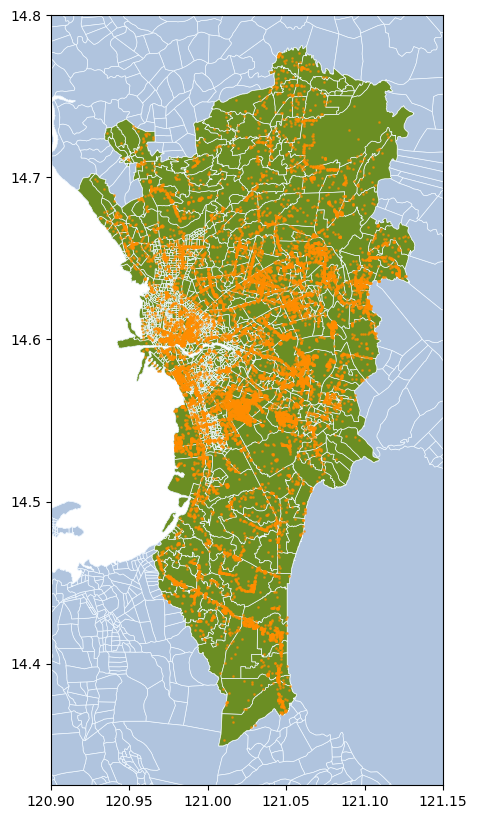

In [50]:
# Slide 6
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom', crs='EPSG:4326')
pts_mm_amenity_new = gpd.GeoDataFrame(pts_mm_amenity_new, geometry='way', crs='EPSG:4326')

ax = shp_ph.plot(figsize=(10, 10),
                 color='lightsteelblue',
                 edgecolor='aliceblue',
                 linewidth=0.5)
shp_mm_new.plot(ax=ax,
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
pts_mm_amenity.plot(ax=ax,
                color='darkorange',
                alpha=0.6,
                markersize=1)
plt.xlim([120.9, 121.15])
plt.ylim([14.325, 14.8]);

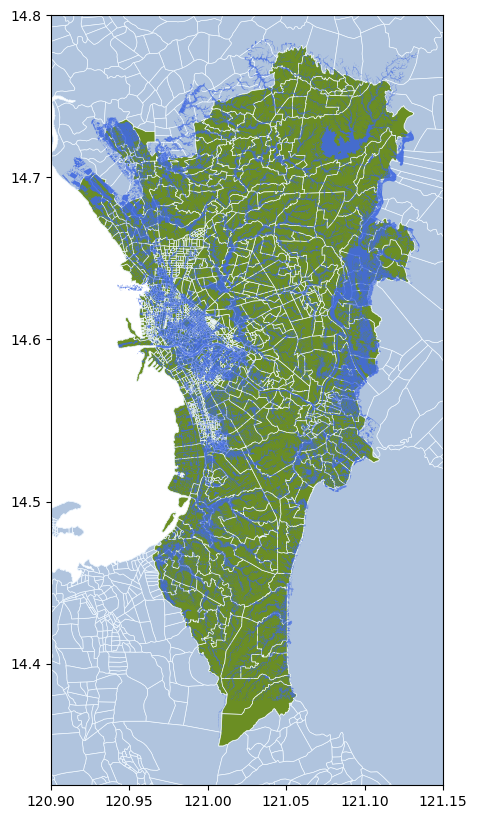

In [51]:
# Slide 6
ax = shp_ph.plot(figsize=(10, 10),
                 color='lightsteelblue',
                 edgecolor='aliceblue',
                 linewidth=0.5)
shp_mm_new.plot(ax=ax,
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
shp_mm_flood.plot(ax=ax,
                  color='royalblue',
                  alpha=0.9)
plt.xlim([120.9, 121.15])
plt.ylim([14.325, 14.8]);

In [52]:
# Slide 7
df_mm_pop[df_mm_pop['mun_city'] == 'City of Navotas'][['mun_city', 'barangay']].sort_values('barangay')

,mun_city,barangay
37949,City of Navotas,Bagumbayan North
37950,City of Navotas,Bagumbayan South
37951,City of Navotas,Bangculasi
37952,City of Navotas,Daanghari
37962,City of Navotas,NBBS Dagat-dagatan
37956,City of Navotas,NBBS Kaunlaran
37963,City of Navotas,NBBS Proper
37953,City of Navotas,Navotas East
37954,City of Navotas,Navotas West
37955,City of Navotas,North Bay Boulevard North


In [53]:
# Slide 7
shp_mm[shp_mm['name_2'] == 'Navotas'][['name_2', 'name_3']].sort_values('name_3')

,name_2,name_3
1208,Navotas,Bagumbayan North
1209,Navotas,Bagumbayan South
1210,Navotas,Bangculasi
1211,Navotas,Daanghari
1213,Navotas,Navotas East
1214,Navotas,"North Bay Blvd., North"
1215,Navotas,"North Bay Blvd., South"
1216,Navotas,San Jose
1217,Navotas,San Rafael Village
1218,Navotas,San Roque


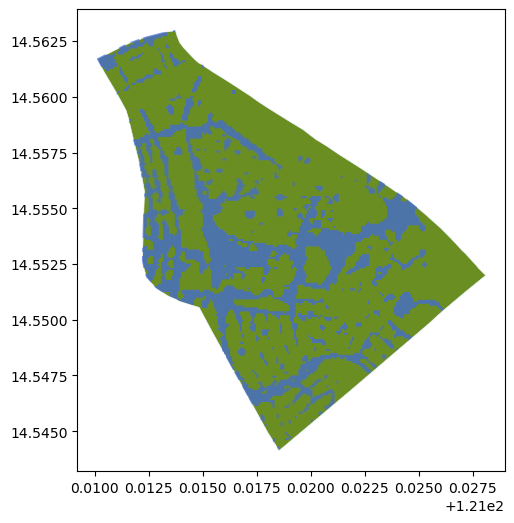

In [54]:
# Slide 8
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom', crs='EPSG:4326')
df_intersection = gpd.GeoDataFrame(df_intersection, geometry='geometry', crs='EPSG:4326')

ax = shp_mm_new[(shp_mm_new['mun_city'] == 'Makati City') & (shp_mm_new['barangay'] == 'San Lorenzo')].plot(figsize=(6, 6),
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
df_intersection[(df_intersection['mun_city'] == 'Makati City') & (df_intersection['barangay'] == 'San Lorenzo')].plot(ax=ax,
                  color='royalblue',
                  alpha=0.7);

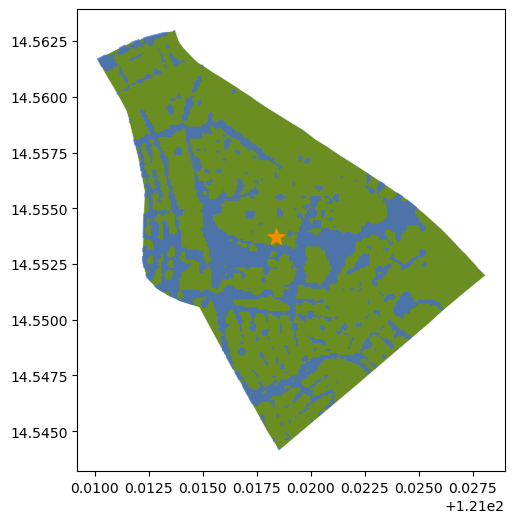

In [55]:
# Slide 8
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom', crs='EPSG:4326')
shp_mm_new_c = gpd.GeoDataFrame(shp_mm_new, geometry='centroid', crs='EPSG:4326')
df_intersection = gpd.GeoDataFrame(df_intersection, geometry='geometry', crs='EPSG:4326')

ax = shp_mm_new[(shp_mm_new['mun_city'] == 'Makati City') & (shp_mm_new['barangay'] == 'San Lorenzo')].plot(figsize=(6, 6),
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
df_intersection[(df_intersection['mun_city'] == 'Makati City') & (df_intersection['barangay'] == 'San Lorenzo')].plot(ax=ax,
                  color='royalblue',
                  alpha=0.7)
shp_mm_new_c[(shp_mm_new_c['mun_city'] == 'Makati City') & (shp_mm_new_c['barangay'] == 'San Lorenzo')].plot(ax=ax,
                color='darkorange',
                alpha=0.9,
                markersize=150,
                marker='*');

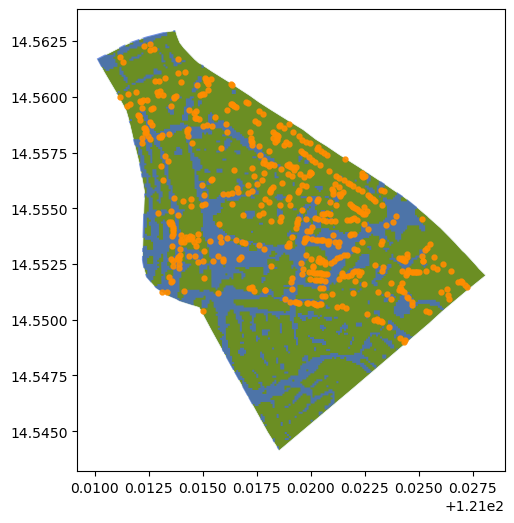

In [56]:
# Slide 8
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom', crs='EPSG:4326')
df_intersection = gpd.GeoDataFrame(df_intersection, geometry='geometry', crs='EPSG:4326')

ax = shp_mm_new[(shp_mm_new['mun_city'] == 'Makati City') & (shp_mm_new['barangay'] == 'San Lorenzo')].plot(figsize=(6, 6),
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
df_intersection[(df_intersection['mun_city'] == 'Makati City') & (df_intersection['barangay'] == 'San Lorenzo')].plot(ax=ax,
                  color='royalblue',
                  alpha=0.7)
pts_mm_amenity_new[(pts_mm_amenity_new['mun_city'] == 'Makati City') & (pts_mm_amenity_new['barangay'] == 'San Lorenzo')].plot(ax=ax,
                color='darkorange',
                alpha=0.9,
                markersize=50,
                marker='.');

In [57]:
# Slide 9
df_affected_pop[['mun_city', 'barangay', 'affected_pop_by_area']].sort_values('affected_pop_by_area', ascending=False).head(10)

,mun_city,barangay,affected_pop_by_area
1453,Pasig City,Pinagbuhatan,122047.645357
1188,Marikina,Concepcion Uno,64097.9377
1449,Pasig City,Manggahan,50970.988549
1493,Quezon City,Batasan Hills,49154.455473
1455,Pasig City,Rosario,46498.732059
1191,Marikina,Malanday,44828.74756
230,Makati City,Post Proper Southside,38343.110604
1450,Pasig City,Maybunga,38119.110917
1463,Pasig City,Santa Lucia,35440.906834
1229,Parañaque,Moonwalk,34152.281922


In [58]:
# Slide 9
df_affected_pop[['mun_city', 'barangay', 'affected_pop_by_centroid']].sort_values('affected_pop_by_centroid', ascending=False).head(10)

,mun_city,barangay,affected_pop_by_centroid
85,Kalookan City,Barangay 176,261729.0
1453,Pasig City,Pinagbuhatan,163598.0
1645,Taguig,Lower Bicutan,116304.0
1561,Quezon City,Pasong Tamo,110738.0
1188,Marikina,Concepcion Uno,92151.0
1449,Pasig City,Manggahan,88078.0
1231,Parañaque,San Dionisio,72522.0
1229,Parañaque,Moonwalk,72520.0
1546,Quezon City,Matandang Balara,69475.0
1484,Quezon City,Bagbag,64653.0


In [59]:
# Slide 9
df_affected_pop[['mun_city', 'barangay', 'affected_pop_by_amenity']].sort_values('affected_pop_by_amenity', ascending=False).head(10)

,mun_city,barangay,affected_pop_by_amenity
1453,Pasig City,Pinagbuhatan,122698.5
1188,Marikina,Concepcion Uno,72750.789474
1562,Quezon City,Payatas,62106.666667
1191,Marikina,Malanday,49740.923077
1449,Pasig City,Manggahan,44696.298507
1521,Quezon City,Gulod,41694.666667
1450,Pasig City,Maybunga,38546.538462
1493,Quezon City,Batasan Hills,37393.714286
1653,Taguig,Ususan,35970.666667
1463,Pasig City,Santa Lucia,34999.2


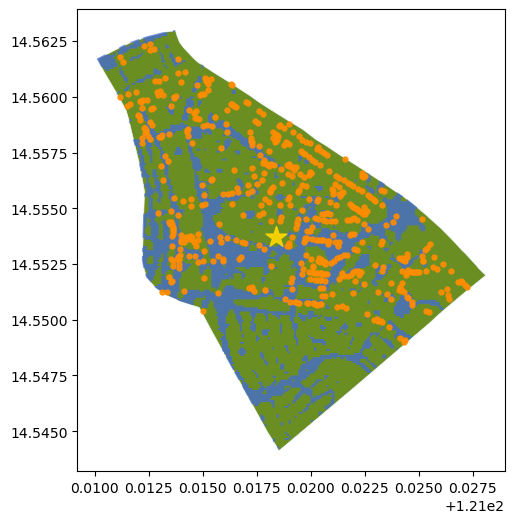

In [60]:
# Slide 10
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom', crs='EPSG:4326')
shp_mm_new_c = gpd.GeoDataFrame(shp_mm_new, geometry='centroid', crs='EPSG:4326')
df_intersection = gpd.GeoDataFrame(df_intersection, geometry='geometry', crs='EPSG:4326')

ax = shp_mm_new[(shp_mm_new['mun_city'] == 'Makati City') & (shp_mm_new['barangay'] == 'San Lorenzo')].plot(figsize=(6, 6),
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
df_intersection[(df_intersection['mun_city'] == 'Makati City') & (df_intersection['barangay'] == 'San Lorenzo')].plot(ax=ax,
                  color='royalblue',
                  alpha=0.7)
shp_mm_new_c[(shp_mm_new_c['mun_city'] == 'Makati City') & (shp_mm_new_c['barangay'] == 'San Lorenzo')].plot(ax=ax,
                color='gold',
                alpha=0.9,
                markersize=250,
                marker='*')
pts_mm_amenity_new[(pts_mm_amenity_new['mun_city'] == 'Makati City') & (pts_mm_amenity_new['barangay'] == 'San Lorenzo')].plot(ax=ax,
                color='darkorange',
                alpha=0.9,
                markersize=50,
                marker='.');

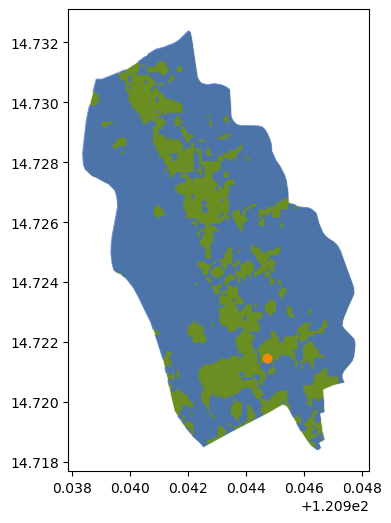

In [61]:
# Slide 11
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom', crs='EPSG:4326')
shp_mm_new_c = gpd.GeoDataFrame(shp_mm_new, geometry='centroid', crs='EPSG:4326')
df_intersection = gpd.GeoDataFrame(df_intersection, geometry='geometry', crs='EPSG:4326')

ax = shp_mm_new[(shp_mm_new['mun_city'] == 'Valenzuela') & (shp_mm_new['barangay'] == 'Tagalag')].plot(figsize=(6, 6),
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
df_intersection[(df_intersection['mun_city'] == 'Valenzuela') & (df_intersection['barangay'] == 'Tagalag')].plot(ax=ax,
                  color='royalblue',
                  alpha=0.7)
pts_mm_amenity_new[(pts_mm_amenity_new['mun_city'] == 'Valenzuela') & (pts_mm_amenity_new['barangay'] == 'Tagalag')].plot(ax=ax,
                color='darkorange',
                alpha=0.9,
                markersize=150,
                marker='.');

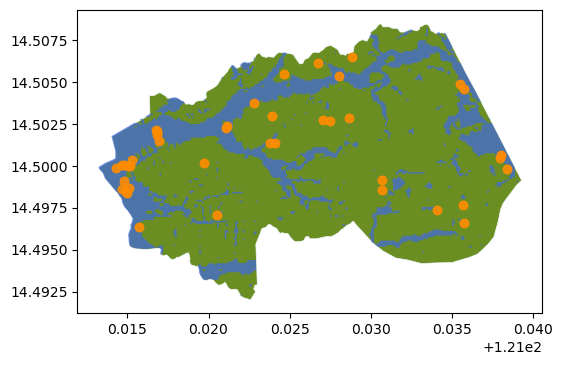

In [62]:
# Slide 11
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom', crs='EPSG:4326')
shp_mm_new_c = gpd.GeoDataFrame(shp_mm_new, geometry='centroid', crs='EPSG:4326')
df_intersection = gpd.GeoDataFrame(df_intersection, geometry='geometry', crs='EPSG:4326')

ax = shp_mm_new[(shp_mm_new['mun_city'] == 'Parañaque') & (shp_mm_new['barangay'] == 'Merville')].plot(figsize=(6, 6),
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
df_intersection[(df_intersection['mun_city'] == 'Parañaque') & (df_intersection['barangay'] == 'Merville')].plot(ax=ax,
                  color='royalblue',
                  alpha=0.7)
pts_mm_amenity_new[(pts_mm_amenity_new['mun_city'] == 'Parañaque') & (pts_mm_amenity_new['barangay'] == 'Merville')].plot(ax=ax,
                color='darkorange',
                alpha=0.9,
                markersize=150,
                marker='.');

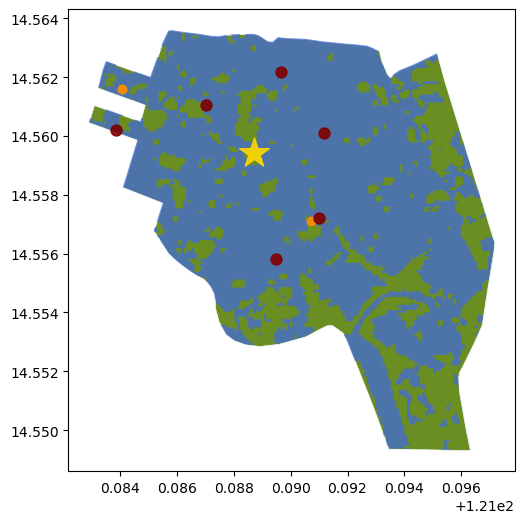

In [63]:
# Slide 15
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom', crs='EPSG:4326')
df_intersection = gpd.GeoDataFrame(df_intersection, geometry='geometry', crs='EPSG:4326')
top_20_affected_barangays = gpd.GeoDataFrame(top_20_affected_barangays, geometry='affected_amenity_centroids', crs='EPSG:4326')

ax = shp_mm_new[(shp_mm_new['mun_city'] == 'Pasig City') & (shp_mm_new['barangay'] == 'Pinagbuhatan')].plot(figsize=(6, 6),
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
df_intersection[(df_intersection['mun_city'] == 'Pasig City') & (df_intersection['barangay'] == 'Pinagbuhatan')].plot(ax=ax,
                  color='royalblue',
                  alpha=0.7)
pts_mm_amenity_new[(pts_mm_amenity_new['mun_city'] == 'Pasig City') & (pts_mm_amenity_new['barangay'] == 'Pinagbuhatan') & (pts_mm_amenity_new['affected_amenity'] == False)].plot(ax=ax,
                color='darkorange',
                alpha=0.9,
                markersize=150,
                marker='.')
pts_mm_amenity_new[(pts_mm_amenity_new['mun_city'] == 'Pasig City') & (pts_mm_amenity_new['barangay'] == 'Pinagbuhatan') & (pts_mm_amenity_new['affected_amenity'] == True)].plot(ax=ax,
                color='maroon',
                alpha=0.9,
                markersize=250,
                marker='.')
top_20_affected_barangays[(top_20_affected_barangays['mun_city'] == 'Pasig City') & (top_20_affected_barangays['barangay'] == 'Pinagbuhatan')].plot(ax=ax,
                color='gold',
                alpha=0.9,
                markersize=500,
                marker='*');

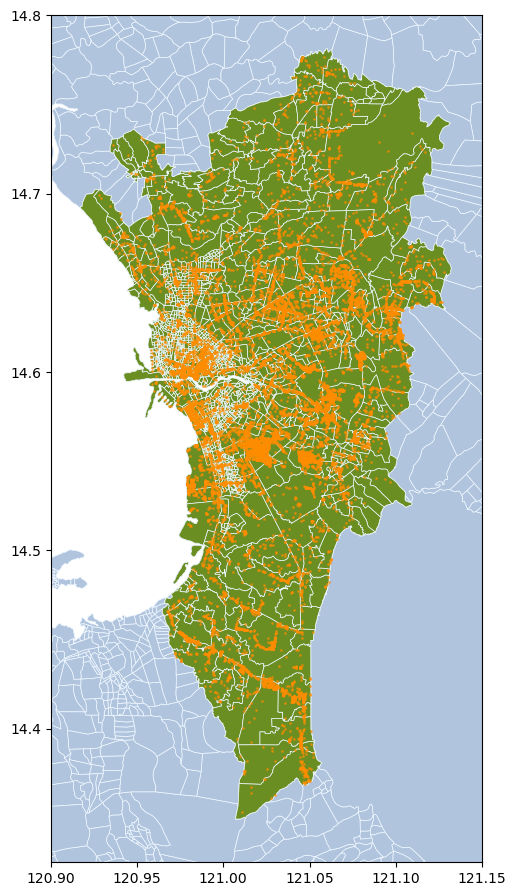

In [64]:
# Slide 16
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom', crs='EPSG:4326')
pts_mm_amenity_new = gpd.GeoDataFrame(pts_mm_amenity_new, geometry='way', crs='EPSG:4326')

ax = shp_ph.plot(figsize=(11, 11),
                 color='lightsteelblue',
                 edgecolor='aliceblue',
                 linewidth=0.5)
shp_mm_new.plot(ax=ax,
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
pts_mm_amenity.plot(ax=ax,
                color='darkorange',
                alpha=0.6,
                markersize=1)
plt.xlim([120.9, 121.15])
plt.ylim([14.325, 14.8]);

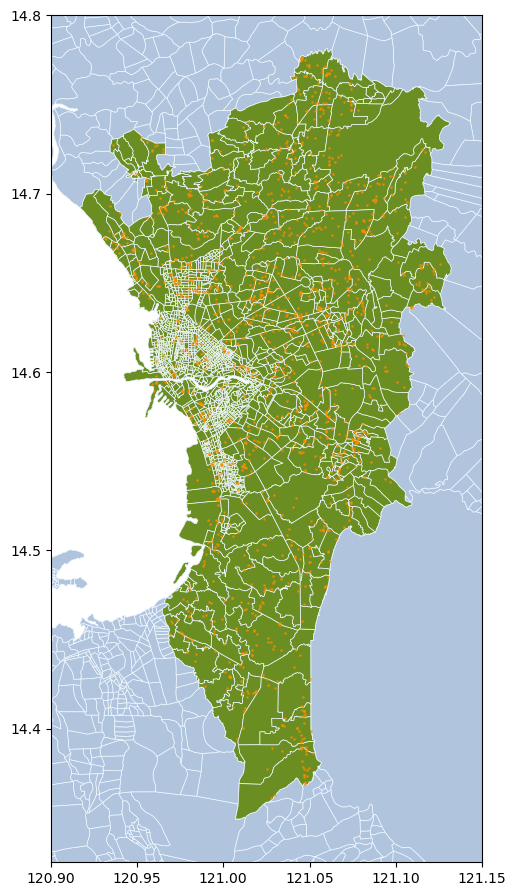

In [65]:
# Slide 16
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom', crs='EPSG:4326')
pts_mm_amenity_new = gpd.GeoDataFrame(pts_mm_amenity_new, geometry='way', crs='EPSG:4326')

ax = shp_ph.plot(figsize=(11, 11),
                 color='lightsteelblue',
                 edgecolor='aliceblue',
                 linewidth=0.5)
shp_mm_new.plot(ax=ax,
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
df_potential_evac_pts.plot(ax=ax,
                color='darkorange',
                alpha=0.6,
                markersize=1)
plt.xlim([120.9, 121.15])
plt.ylim([14.325, 14.8]);

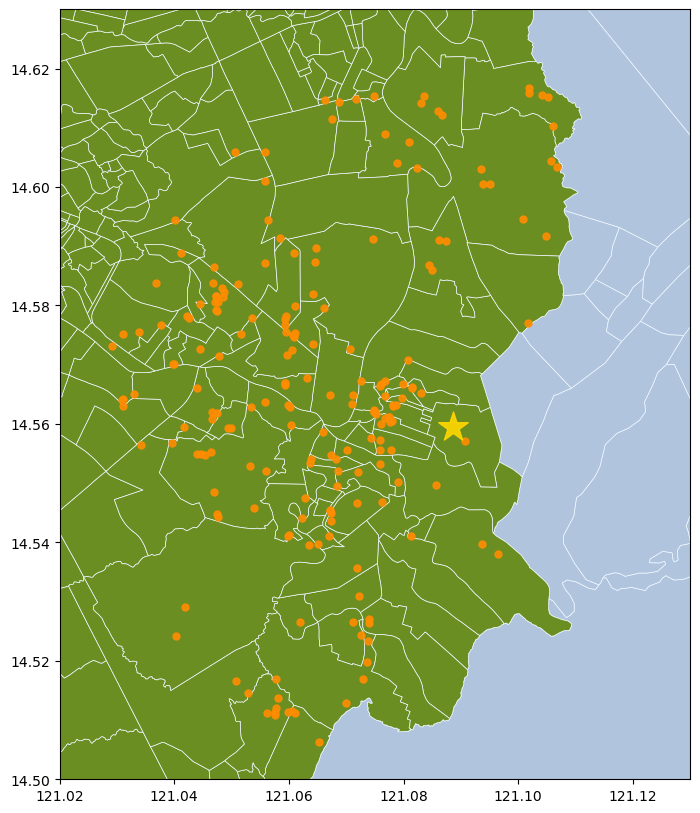

In [66]:
# Slide 17
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom', crs='EPSG:4326')
top_20_affected_barangays = gpd.GeoDataFrame(top_20_affected_barangays, geometry='affected_amenity_centroids', crs='EPSG:4326')

ax = shp_ph.plot(figsize=(10, 10),
                 color='lightsteelblue',
                 edgecolor='aliceblue',
                 linewidth=0.5)
shp_mm_new.plot(ax=ax,
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
top_20_affected_evac_pts[(top_20_affected_evac_pts['mun_city_for_evac'] == 'Pasig City') & (top_20_affected_evac_pts['barangay_for_evac'] == 'Pinagbuhatan')].plot(ax=ax,
                color='darkorange',
                alpha=0.9,
                markersize=100,
                marker='.')
top_20_affected_barangays[(top_20_affected_barangays['mun_city'] == 'Pasig City') & (top_20_affected_barangays['barangay'] == 'Pinagbuhatan')].plot(ax=ax,
                color='gold',
                alpha=0.9,
                markersize=500,
                marker='*')
plt.xlim([121.02, 121.13])
plt.ylim([14.5, 14.63]);

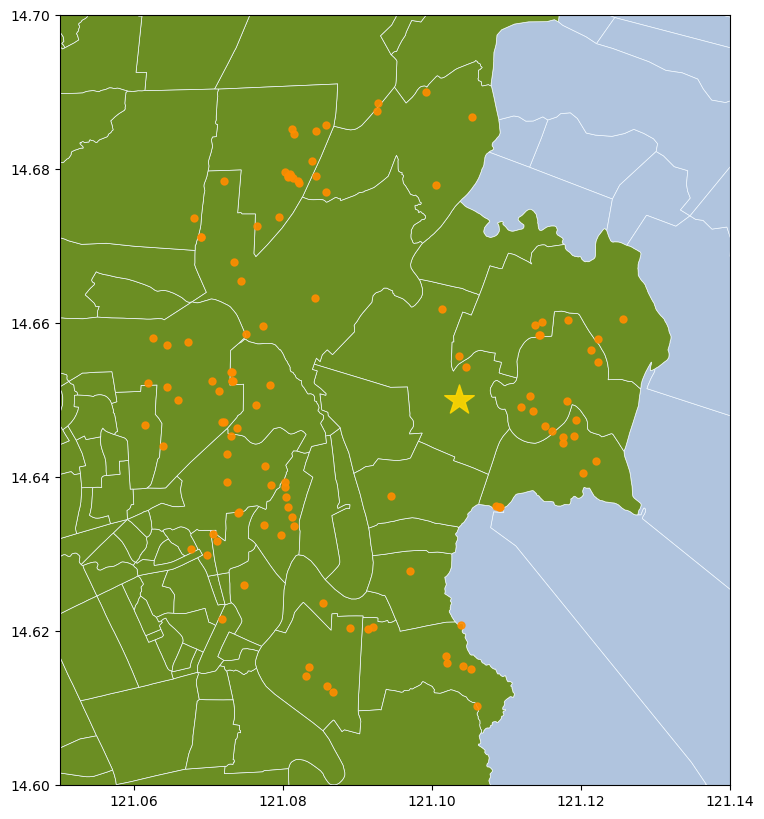

In [67]:
# Slide 18
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom', crs='EPSG:4326')
top_20_affected_barangays = gpd.GeoDataFrame(top_20_affected_barangays, geometry='affected_amenity_centroids', crs='EPSG:4326')

ax = shp_ph.plot(figsize=(10, 10),
                 color='lightsteelblue',
                 edgecolor='aliceblue',
                 linewidth=0.5)
shp_mm_new.plot(ax=ax,
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
top_20_affected_evac_pts[(top_20_affected_evac_pts['mun_city_for_evac'] == 'Marikina') & (top_20_affected_evac_pts['barangay_for_evac'] == 'Concepcion Uno')].plot(ax=ax,
                color='darkorange',
                alpha=0.9,
                markersize=100,
                marker='.')
top_20_affected_barangays[(top_20_affected_barangays['mun_city'] == 'Marikina') & (top_20_affected_barangays['barangay'] == 'Concepcion Uno')].plot(ax=ax,
                color='gold',
                alpha=0.9,
                markersize=500,
                marker='*')
plt.xlim([121.05, 121.14])
plt.ylim([14.6, 14.7]);

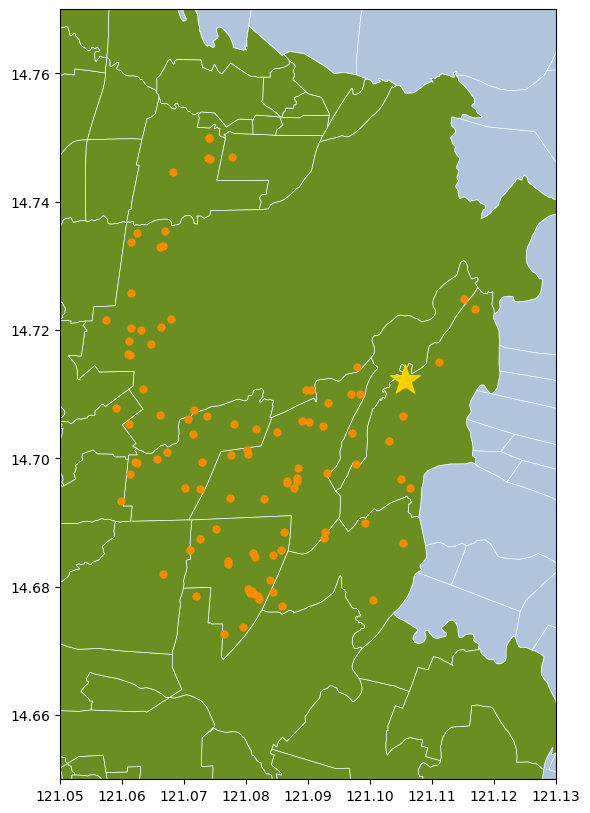

In [68]:
# Slide 18
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom', crs='EPSG:4326')
top_20_affected_barangays = gpd.GeoDataFrame(top_20_affected_barangays, geometry='affected_amenity_centroids', crs='EPSG:4326')

ax = shp_ph.plot(figsize=(10, 10),
                 color='lightsteelblue',
                 edgecolor='aliceblue',
                 linewidth=0.5)
shp_mm_new.plot(ax=ax,
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
top_20_affected_evac_pts[(top_20_affected_evac_pts['mun_city_for_evac'] == 'Quezon City') & (top_20_affected_evac_pts['barangay_for_evac'] == 'Payatas')].plot(ax=ax,
                color='darkorange',
                alpha=0.9,
                markersize=100,
                marker='.')
top_20_affected_barangays[(top_20_affected_barangays['mun_city'] == 'Quezon City') & (top_20_affected_barangays['barangay'] == 'Payatas')].plot(ax=ax,
                color='gold',
                alpha=0.9,
                markersize=500,
                marker='*')
plt.xlim([121.05, 121.13])
plt.ylim([14.65, 14.77]);

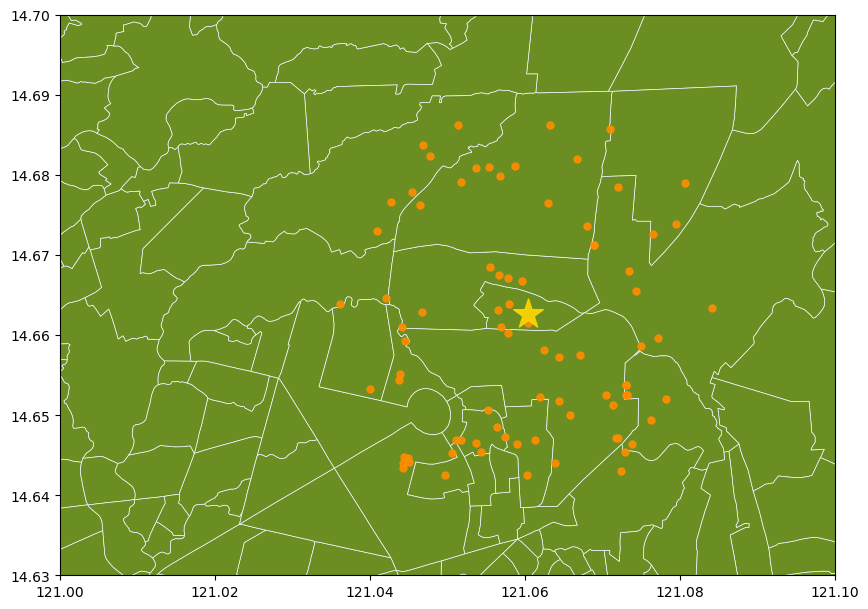

In [69]:
# Slide 18
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom', crs='EPSG:4326')
top_20_affected_barangays = gpd.GeoDataFrame(top_20_affected_barangays, geometry='affected_amenity_centroids', crs='EPSG:4326')

ax = shp_ph.plot(figsize=(10, 10),
                 color='lightsteelblue',
                 edgecolor='aliceblue',
                 linewidth=0.5)
shp_mm_new.plot(ax=ax,
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
top_20_affected_evac_pts[(top_20_affected_evac_pts['mun_city_for_evac'] == 'Marikina') & (top_20_affected_evac_pts['barangay_for_evac'] == 'Malanday')].plot(ax=ax,
                color='darkorange',
                alpha=0.9,
                markersize=100,
                marker='.')
top_20_affected_barangays[(top_20_affected_barangays['mun_city'] == 'Marikina') & (top_20_affected_barangays['barangay'] == 'Malanday')].plot(ax=ax,
                color='gold',
                alpha=0.9,
                markersize=500,
                marker='*')
plt.xlim([121, 121.1])
plt.ylim([14.63, 14.7]);

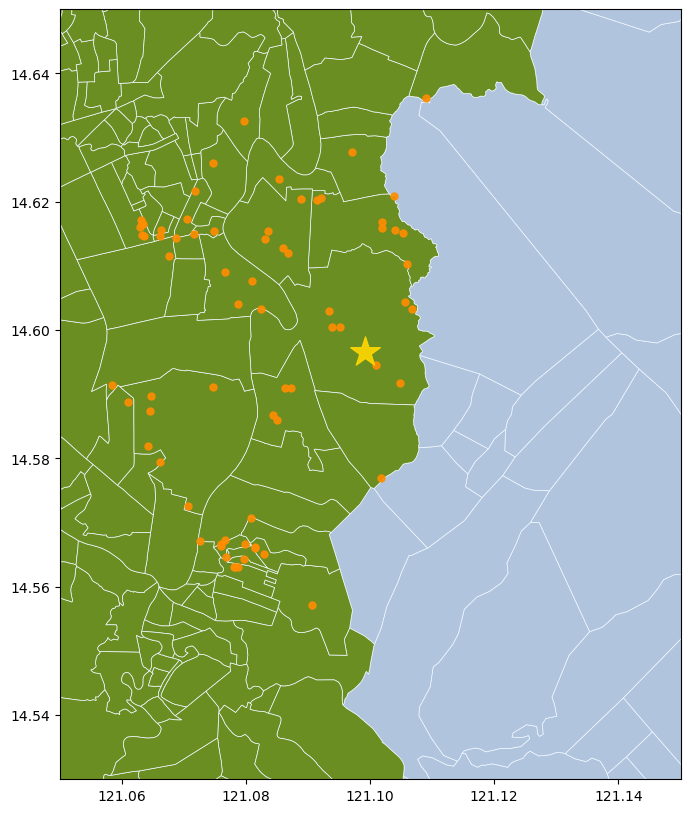

In [70]:
# Slide 18
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom', crs='EPSG:4326')
top_20_affected_barangays = gpd.GeoDataFrame(top_20_affected_barangays, geometry='affected_amenity_centroids', crs='EPSG:4326')

ax = shp_ph.plot(figsize=(10, 10),
                 color='lightsteelblue',
                 edgecolor='aliceblue',
                 linewidth=0.5)
shp_mm_new.plot(ax=ax,
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
top_20_affected_evac_pts[(top_20_affected_evac_pts['mun_city_for_evac'] == 'Pasig City') & (top_20_affected_evac_pts['barangay_for_evac'] == 'Manggahan')].plot(ax=ax,
                color='darkorange',
                alpha=0.9,
                markersize=100,
                marker='.')
top_20_affected_barangays[(top_20_affected_barangays['mun_city'] == 'Pasig City') & (top_20_affected_barangays['barangay'] == 'Manggahan')].plot(ax=ax,
                color='gold',
                alpha=0.9,
                markersize=500,
                marker='*')
plt.xlim([121.05, 121.15])
plt.ylim([14.53, 14.65]);

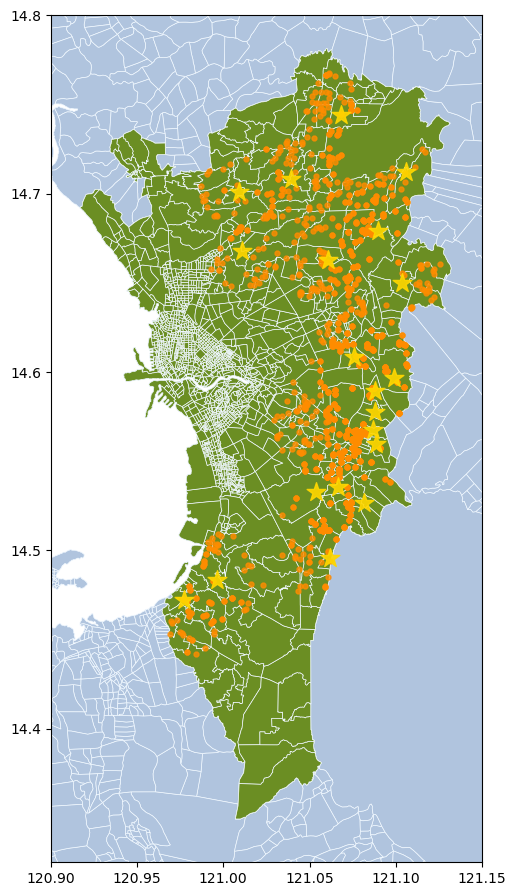

In [71]:
# Slide 19
shp_mm_new = gpd.GeoDataFrame(shp_mm_new, geometry='brgy_geom', crs='EPSG:4326')
top_20_affected_barangays = gpd.GeoDataFrame(top_20_affected_barangays, geometry='affected_amenity_centroids', crs='EPSG:4326')

ax = shp_ph.plot(figsize=(11, 11),
                 color='lightsteelblue',
                 edgecolor='aliceblue',
                 linewidth=0.5)
shp_mm_new.plot(ax=ax,
            color='olivedrab',
            edgecolor='aliceblue',
            linewidth=0.5)
top_20_affected_evac_pts.plot(ax=ax,
                color='darkorange',
                alpha=0.8,
                markersize=50,
                marker='.')
top_20_affected_barangays.plot(ax=ax,
                color='gold',
                alpha=0.9,
                markersize=200,
                marker='*')
plt.xlim([120.9, 121.15])
plt.ylim([14.325, 14.8]);